# はじめに

このノートではLightGBMを理解するために、下記のmeanxaiの動画を参考にしながら、LightGBMのアルゴリズムについて理解を深める。

- [[MXML-12-02] Light GBM [2/5] - Gradient-based One-Side Sampling (GOSS) ](https://www.youtube.com/watch?v=APZyWo9hIj0&t=33s)

今回は、Gradient-based One-Side Sampling(GOSS)アルゴリズムに焦点をあてる。

## Gradient-based One-Side Sampling(GOSS)アルゴリズム

GOSSアルゴリズムは、勾配の情報をもとにサンプリングすることで計算を減らし、高速化するためのアルゴリズム。RandomForestやXGboostなどのアルゴリズムは、学習効率を高めるために特徴量をサンプリングしている。LightGBMも同様、GOSSアルゴリズムに従って、サンプリングを行う。サンプリングをする基準は、構内の残差の絶対値の大きさを考慮して実行される。つまり、残差が小さいデータは反復して訓練する際に、十分に訓練されているものとして除外する。

まずは簡単なデータを使ってGOSSアルゴリズムのイメージを理解する。左側の表がデータセットで、20件あるとする。右側は左側の表を$|-g|$の値を基準に降順に並び替えたもの。

|no|x1|x2|y| abs(-g)|→→→|no|x1|x2|y| abs(-g)|
|:---|:---|:---|:---|:---|:---|:---|:---|:---|:---|:---|
|1|-0.4|-1.3|0|1.3|→→→|3|0.8|0.3|1|2.8|
|2|1.8|1.7|1|0.2  |→→→|5|1.5|2.8|0|1.5|
|3|0.8|0.3|1|2.8  |→→→|1|-0.4|-1.3|0|1.3|
|4|-1.2|-0.7|0|1.0|→→→|4|-1.2|-0.7|0|1.0|
|5|1.5|2.8|0|1.5  |→→→|6|-0.4|0.3|1|0.8|
|6|-0.4|0.3|1|0.8 |→→→|2|1.8|1.7|1|0.2|

ここで`a: topN`を考える。この指標は大きい勾配のサンプリング率を決めるもので、`b: randN`は小さい勾配のサンプリング率を決めるもの。`a=0.15,b=0.3`とすると、データ件数をかけ合わせ`20*0.15=3`、勾配の大きい上位3件を残し、`b`にも同様にデータ件数をかけ合わせ`20*0.3=6`、4番目に勾配の大きいものから20番目のデータの中から、6個ランダムサンプリングして学習データを構成する。つまり9個のデータが学習に使用される。

ここで問題となるのが、ランダムサンプリングをしてしまうと、$\sum g$を計算する際に数が合わない。そのため、これを調整するための補正項`fact`を導入する。`topN`のデータ点には1.0の重みが与えられ、`randN`のデータ点には2.83の重みが与えられる。`randN`のデータの$\sum g$と$\sum h$を計算するとき、17個の$g$と17個の$h$を足さなければならないが、6個しか足されていないので、2.83を掛け(2.83 * 6 = 17)、存在していたかのように近似して調整する。この調整を行った値をもとにHistogram-based split findingが実行される。

\begin{aligned} 
\sum_{1}^{20} &\simeq& \sum_{1}^{3} g + \sum_{1}^{6} g * \frac{17}{6} \\
\end{aligned}

\begin{aligned} 
fact&= \frac{1-a}{b} = \frac{1-0.15}{0.3} = \frac{17}{6} = 2.83 
\end{aligned}

イメージを理解したところで、実際のGOSSアルゴリズムの手順をまとめておく。まずはインプットデータとして、訓練データ`I`、反復回数`d`、大きい勾配のサンプリング率`a`、小さい勾配のサンプリング率`b`、損失関数`loss`、弱学習器`L`を用意する。`a,b`を決めると`fact`が決まり、`TopN, randN`も決まる。あとは反復`d`回の繰り返しごとに下記を適用する。

1. 1つ前の反復から予測値を計算する
2. 新しい残差`g`を計算する
3. 残差`g`を降順に並び替える
4. `TopN, randN`のデータセットを構成する
5. `randN`の重み`w`を`fact`で補正する
6. 新しく弱学習器`L`を構築する

## Gradient-based One-Side Sampling(GOSS)アルゴリズムの実装 

In [10]:
import numpy as np
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Create a training dataset
x, y = make_blobs (n_samples=10000, n_features=2, centers=[[0., 0.], [0.5, 0.5]], cluster_std=0.25, center_box=(-1., 1.))

# Check the prediction results and the decision boundary.
def check_result(x, y, x_test, y_pred, title):
  plt.figure(figsize=(4,4))
  color2 = [['red', 'blue'][a] for a in y_pred]
  plt.scatter(x_test[:, 0], x_test[:, 1], s=50, c=color2, alpha=0.3)

  # Only part of the training data is drawn.
  plt.scatter(x[:300, 0], x[:300, 1], s=25, c='black')
  plt.scatter(x[:300, 0], x[:300, 1], s=5, c='yellow')
  plt.xlim(-1.0, 1.5)
  plt.ylim(-1.0, 1.5)
  plt.title(title)
  plt.show()


xgboostライブラリを利用して、GOSSを利用して学習する部分をスクラッチで実装する。

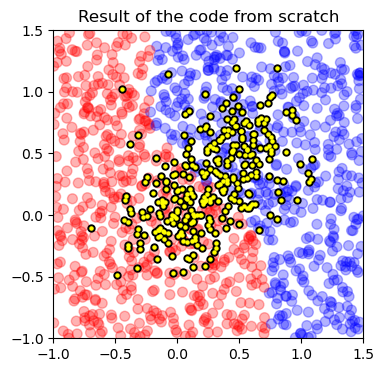

In [11]:
n_boost = 50
eta = 0.3
max_depth = 2 

def base_model(x, y, weights, F0):
  model = XGBClassifier(n_estimators=1, learning_rate=eta, max_depth=max_depth, max_bin=20, tree_method='hist', base_score=None)
  model.fit(x, y, sample_weight=weights, base_margin=F0)
  return model

# Algorithm 2: Gradient-based One-Side Sampling (GOSS)
a = 0.3
b = 0.2
fact = (1. - a)/b
topN  = int(a * x.shape[0])
randN = int(b * x.shape[0])
models = []
Fm = np.zeros(y.shape) # 初期値予測値は0

for i in range(n_boost):
  y_prev = 1. / (1. + np.exp(- Fm))
  g = -(y - y_prev) # 負の残差、一時勾配を計算
  w = np.ones(shape=x.shape[0]) # 初期の重みを1に初期化
  sorted_g = np.argsort(np.abs(g))[::-1] # 並び替え
  topSet = sorted_g[:topN] # TopNデータセットを作成
  randSet = np.random.choice(sorted_g[topN:], size=randN, replace=False) # randNデータセットを作成
  usedSet = np.hstack([topSet, randSet]) # TopN+randNデータセットを作成
  w[randSet] *= fact # factで調整する

  newModel = base_model(x[usedSet], y[usedSet], w[usedSet], F0=Fm[usedSet])
  Fm += newModel.predict(x, output_margin=True)
  models.append(newModel)

# テストデータを作成し、予測する
x_test = np.random.uniform(-1.0, 1.5, (1000, 2))

test_Fm = np.zeros(x_test.shape[0])
for model in models:
  test_Fm += model.predict(x_test, output_margin=True)

# log(odds) -> probability
y_prob = 1. / (1. + np.exp(-test_Fm)) 
y_pred = (y_prob > 0.5) * 1
  
check_result(x, y, x_test, y_pred, "Result of the code from scratch")



[LightGBM] [Info] Number of positive: 5000, number of negative: 5000
[LightGBM] [Info] Total Bins 40
[LightGBM] [Info] Number of data points in the train set: 10000, number of used features: 2
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


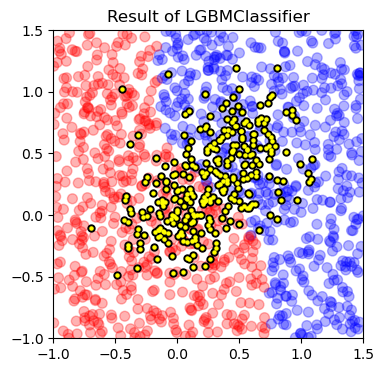

In [20]:
# Use LGBMClassifier library
model = LGBMClassifier(
  n_estimators=20, 
  max_depth=max_depth, 
  learning_rate=eta, 
  max_bin=20, 
  top_rate=0.3, 
  other_rate=0.2, 
  data_sample_strategy='goss', 
  force_col_wise=True)
model.fit(x, y)
y_pred = model.predict(x_test)
check_result(x, y, x_test, y_pred, "Result of LGBMClassifier")